In [1]:
from ActiveTestingRegression import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Nonlinear Regression - 1D data

In [ ]:
rng = np.random.RandomState(2)

N = 60
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)
data = np.sort(rng.rand(N) * len_data - len_data / 2)
noise = rng.randn(N) * 0.1
target = data ** 3 - 0.5 * data ** 2 +  noise

X, y = data, target 

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=15) # 11

# learner  
reg_learner = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("std", StandardScaler()),
            ("linear_regression", Ridge())])


reg_learner.fit(X_train[:,np.newaxis], y_train)

y_pred = reg_learner.predict(X_test[:,np.newaxis])

full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

print(full_loss)


In [ ]:
num_exp = 100 
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_var_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform (Var only), weighted (unbiased)


for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train[:,np.newaxis], y_train, X_test[:,np.newaxis], y_pred,
                                                    M, input_shape=(1,), hidden_units=5, dropout_rate = 0.1,
                                                      learning_rate = 0.01,  mode='BiasVar', loss=quadratic_loss)

        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        
        # Var only, weighted 
        observed_idx, weights = surrogate_sampling(X_train[:,np.newaxis], y_train, X_test[:,np.newaxis], y_pred,
                                                    M, input_shape=(1,), hidden_units=5, dropout_rate = 0.1,
                                                      learning_rate = 0.01,  mode='Var', loss=quadratic_loss)
        result_var_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

In [ ]:
from scipy.io import savemat, loadmat 
mdic = {"result_uni": result_uni,
        "result_mod_weighted": result_mod_weighted,
        "result_mod_unweighted": result_mod_unweighted,
        "result_var_weighted": result_var_weighted}

savemat("results_synthetic.mat", mdic)

In [ ]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - 1.5*  calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=4, label='Uniform')
ax.bar(M_values  - 0.5*  calc_width, result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=4, label='BNN, unweighted')
ax.bar(M_values + 0.5*  calc_width, result_var_weighted.mean(axis=0), yerr= result_var_weighted.std(axis=0).reshape(1,-1), color = 'salmon', ecolor='maroon', width = calc_width, capsize=4, label='Var, weighted')
ax.bar(M_values + 1.5*  calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=4, label='BNN, weighted')

plt.axhline(y = full_loss, color = 'k', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'syn_bnn_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=400)
plt.show()

### Real problem 1

In [2]:
df = pd.read_excel('ENB2012_data.xlsx')

X = df.iloc[:,:7].to_numpy()

y = df['Y1'].to_numpy()

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=15) # 11

# train 
reg_learner = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("std", StandardScaler()),
            ("linear_regression", Ridge())])


reg_learner.fit(X_train, y_train)

y_pred = reg_learner.predict(X_test)

full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

print(full_loss, X_test.shape)



2.4078988471574037 (384, 7)


In [3]:
num_exp = 50 
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_var_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform (Var only), weighted (unbiased)


for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train, X_test, y_pred,
                                                    M, input_shape=(7,), hidden_units=10, dropout_rate = 0.1,
                                                      learning_rate = 0.01,  mode='BiasVar', loss=quadratic_loss)

        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        
        # Var only, weighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train, X_test, y_pred,
                                                    M, input_shape=(7,), hidden_units=10, dropout_rate = 0.1,
                                                      learning_rate = 0.01,  mode='Var', loss=quadratic_loss)
        result_var_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

---38---
---76---
---115---
---153---
---192---


In [4]:
from scipy.io import savemat, loadmat 
mdic = {"result_uni": result_uni,
        "result_mod_weighted": result_mod_weighted,
        "result_mod_unweighted": result_mod_unweighted,
        "result_var_weighted": result_var_weighted}

savemat("results_energy.mat", mdic)

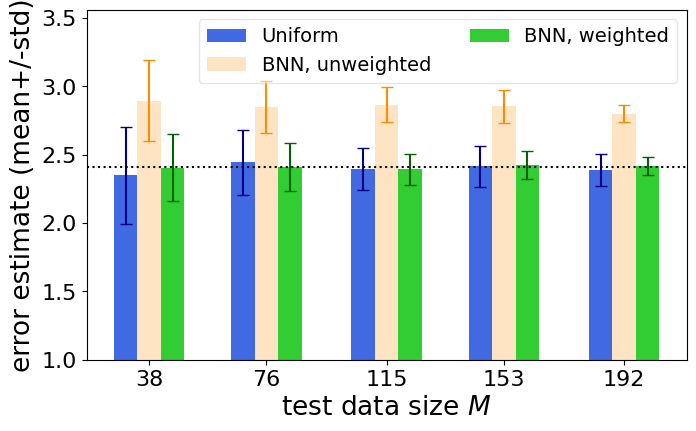

In [14]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - 1*  calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=4, label='Uniform')
ax.bar(M_values, result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=4, label='BNN, unweighted')
ax.bar(M_values + 1*  calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=4, label='BNN, weighted')

plt.axhline(y = full_loss, color = 'k', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(1,result_mod_unweighted.max())
ax.legend(ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'energy_bnn_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=400)
plt.show()

In [ ]:
result_mod_weighted.std(axis=0)/result_uni.std(axis=0)

### Real problem 2

https://www.kaggle.com/code/nityasreepaladugu/predicting-concrete-compressive-strength-with-ml/notebook

In [ ]:
data = pd.read_csv("DataConc.csv")

data.head()

In [ ]:
X = data.iloc[:,:-1].to_numpy()         # Features - All columns but last
y = data.iloc[:,-1].to_numpy()          # Target - Last Column

In [ ]:
X.shape, y.shape

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

X = StandardScaler().fit_transform(X)

# D_train and D_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1) # 15

# train 
reg_learner = DecisionTreeRegressor()


reg_learner.fit(X_train, y_train)

y_pred = reg_learner.predict(X_test)

# evaluator 1 

# search = GridSearchCV(
#     SVR(kernel="rbf"),
#     param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
#     scoring='neg_root_mean_squared_error')


# search.fit(X_train, y_train)

# search.best_params_

In [ ]:

reg_evaluator = RandomForestRegressor(n_estimators=10)


#reg_evaluator = SVR(kernel="rbf", gamma=search.best_params_["gamma"],
#                    C=search.best_params_["C"])

In [ ]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
        # uniform 
        observed_idx = np.random.choice(N, M, replace=False)
        weights = np.ones(M)/M 
        result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

In [ ]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate RF, unweighted',  'surrogate RF, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'concrete_RF_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()


In [ ]:
result_uni.std(axis=0)

In [ ]:
result_mod_weighted.std(axis=0)

In [ ]:
full_loss

In [ ]:
# evaluator 2 

# from sklearn.ensemble import ExtraTreesRegressor

# reg_evaluator = ExtraTreesRegressor(n_estimators=100)

# from sklearn.ensemble import BaggingRegressor

# from sklearn.tree import ExtraTreeRegressor

# reg_evaluator = BaggingRegressor(ExtraTreeRegressor())

from sklearn.ensemble import AdaBoostRegressor

reg_evaluator = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), n_estimators=10)


In [ ]:
num_exp = 100
N = len(X_test)
M_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) * N
M_values = M_values.astype(int)
#result_uni = np.zeros((num_exp, len(M_values))) # uniform 
result_mod_unweighted = np.zeros((num_exp, len(M_values))) # nonuniform, unweighted (biased)
result_mod_weighted   = np.zeros((num_exp, len(M_values))) # nonuniform, weighted (unbiased)

for i in range(len(M_values)):    
    M = M_values[i]
    print('---' + str(M) + '---')
    
    for exp in range(num_exp):
#         # uniform 
#         observed_idx = np.random.choice(N, M, replace=False)
#         weights = np.ones(M)/M 
#         result_uni[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
#                        weights, quadratic_loss, mode='unweighted'))
        
        # nonuniform, unweighted 
        observed_idx, weights = surrogate_sampling(X_train, y_train,
                                           X_test, y_pred, M, reg_evaluator, loss=quadratic_loss)
        
        result_mod_unweighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='unweighted'))

        # nonuniform, weighted 
        result_mod_weighted[exp, i] = np.sqrt(risk_estimator_partial(y_test[observed_idx], y_pred[observed_idx], N,  
                       weights, quadratic_loss, mode='weighted'))
        

In [ ]:
full_loss = np.sqrt(quadratic_loss(y_test, y_pred).mean())

# plot results  
plt.rcParams.update({'font.size': 16, "figure.figsize": (6,3.5)})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
calc_width = 0.2 * (M_values[1] - M_values[0])
ax.bar(M_values - calc_width, result_uni.mean(axis=0), yerr= result_uni.std(axis=0).reshape(1,-1), color = 'royalblue', ecolor='darkblue', width = calc_width, capsize=3)
ax.bar(M_values , result_mod_unweighted.mean(axis=0), yerr= result_mod_unweighted.std(axis=0).reshape(1,-1), color = 'bisque', ecolor='darkorange', width = calc_width, capsize=3)
ax.bar(M_values + calc_width, result_mod_weighted.mean(axis=0), yerr= result_mod_weighted.std(axis=0).reshape(1,-1), color = 'limegreen', ecolor='darkgreen', width = calc_width, capsize=3)

plt.axhline(y = full_loss, color = 'r', linestyle = ':')
ax.set_xticks(M_values)
ax.set_ylabel('error estimate (mean+/-std)', fontsize=19)
ax.set_xlabel('test data size $M$', fontsize=19)
ax.set_ylim(0,result_mod_unweighted.max())
ax.legend(labels=['test error $R$', 'uniform', 'surrogate AdaBoost, unweighted',  'surrogate AdaBoost, weighted'], ncol=2, fontsize=14, framealpha=0.5)
fig_name = 'concrete_Ada_acc.png'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
np.mean(result_uni.std(axis=0)/result_mod_weighted.std(axis=0))

In [ ]:
result_mod_weighted.std(axis=0)